<a href="https://colab.research.google.com/github/surajsrivathsa/image_registration/blob/main/MRI_Data_Harmonization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
# !pip install --upgrade nibabel

In [1]:
import warnings
import os
warnings.filterwarnings("ignore")
import numpy as np
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import nibabel as nb
import os, sys, glob
from google.colab import drive
drive.mount('/content/drive')
print()

1.8.0+cu101
0.9.0+cu101
Mounted at /content/drive



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import collections

In [116]:
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [6]:
data_path_t1 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/"
data_path_t2 = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/T1_Train_200_Reg_downsampled_znm/"
ixi_xls_path = "/content/drive/My Drive/Image_Registration_Project/dataset_ants_resampled/IXI.xls"
file_names_t1 = sorted(glob.glob(os.path.join(data_path_t1, "*.nii.gz")))
file_names_t2 = sorted(glob.glob(os.path.join(data_path_t2, "*.nii.gz")))

In [7]:
ixi_df = pd.read_excel(ixi_xls_path, sheet_name="Table")
ixi_df.head()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,1,1,170,80,2,3,5,2,1968-02-22,0,NaT,NaN
1,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137
2,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656
3,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472
4,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824


In [8]:
ixi_df.describe()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DATE_AVAILABLE,AGE
count,619.000000,619.000000,619.000000,619.000000,619.000000,619.000000,619.00000,619.000000,619.000000,590.000000
mean,335.399031,1.552504,160.466882,70.195477,1.374798,2.016155,2.50727,3.733441,0.957997,49.416235
std,185.351230,0.497638,99.604071,56.802863,1.122762,1.280826,2.05535,1.662949,0.200759,16.715313
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,19.980835
25%,176.500000,1.000000,160.000000,60.000000,1.000000,1.000000,1.00000,3.000000,1.000000,34.000000
50%,341.000000,2.000000,168.000000,70.000000,1.000000,2.000000,1.00000,5.000000,1.000000,50.611910
75%,498.000000,2.000000,176.000000,80.000000,1.000000,3.000000,5.00000,5.000000,1.000000,63.355921
max,662.000000,2.000000,1850.000000,960.000000,6.000000,5.000000,8.00000,5.000000,1.000000,86.318960


duplicate records in ixi excel file must be dropped to ensure one-one join later

In [9]:
ixi_df.drop_duplicates(subset=['IXI_ID'], keep='first', inplace=True)

In [10]:
count = 0
ixi_id = []
scanner_name = []
contrast_type = []
file_path = []
for root, dirs, files in os.walk(data_path_t1):
  for file in files:
    parameters_search = re.search('reg_IXI(\d*)-(\w*)-(\d*)-(\w*)_downsampled_hm_zscore(.*?)', file, re.IGNORECASE)
    
    if parameters_search:
      ixi_id.append(int(parameters_search.group(1)))
      scanner_name.append(parameters_search.group(2))
      contrast_type.append(parameters_search.group(4))
      file_path.append(os.path.join(data_path_t1, file))
  
    count = count+1
  
  print("processed {} files".format(count))

processed 201 files


check for ixi_id duplicates in our regexed list

In [ ]:
print([item for item, count in collections.Counter(ixi_id).items() if count > 1])

[]


In [ ]:
contrast_type[0:3]

['T1', 'T1', 'T1']

In [ ]:
scanner_name[0:3]

['IOP', 'Guys', 'Guys']

In [ ]:
ixi_id[0:3]

[433, 429, 431]

In [11]:
our_df = pd.DataFrame(data={ "our_ixi_id": ixi_id, "scanner_name": scanner_name, "contrast_type": contrast_type, "file_path": file_path} )
our_df.head()

,our_ixi_id,scanner_name,contrast_type,file_path
0,433,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...
1,429,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
2,431,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
3,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...
4,432,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...


IOP scanner info is pretty less, In each batch there should be atleast some IOP. Both learning and unlearning. Ofcourse this has to be decided based on age.

In [12]:
filtered_df = pd.merge(left = ixi_df, right=our_df, left_on="IXI_ID", right_on="our_ixi_id", how="inner", validate="one_to_one")

In [13]:
filtered_df.head()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path
0,60,1,180,75,1,2,1,5,1974-10-26,1,2005-07-08,30.699521,60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
1,428,2,163,75,1,2,1,4,1951-01-08,1,2006-07-24,55.540041,428,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
2,429,2,155,61,1,2,2,4,1951-01-08,1,2006-07-24,55.540041,429,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...
3,430,2,166,70,1,4,5,5,1934-07-02,1,2006-07-04,72.005476,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...
4,431,2,163,58,1,2,2,5,1947-10-05,1,2006-07-17,58.781656,431,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...


discretize age into bins of 10

In [14]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"]
filtered_df['age_disc'] = pd.cut(filtered_df['AGE'], bins=bins, labels=labels)

In [15]:
filtered_df[(filtered_df["scanner_name"] == "IOP") & (filtered_df["age_disc"].isin(["50-60", "60-70"]) ) ].describe()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DATE_AVAILABLE,AGE,our_ixi_id
count,5.000000,5.000000,5.00000,5.00000,5.0,5.000000,5.000000,5.00000,5.0,5.000000,5.000000
mean,494.200000,1.600000,163.40000,69.60000,1.0,1.600000,5.200000,4.20000,1.0,62.729090,494.200000
std,63.365606,0.547723,12.54193,18.98157,0.0,0.547723,0.447214,1.30384,0.0,7.282813,63.365606
min,434.000000,1.000000,153.00000,50.00000,1.0,1.000000,5.000000,2.00000,1.0,50.573580,434.000000
25%,442.000000,1.000000,157.00000,59.00000,1.0,1.000000,5.000000,4.00000,1.0,61.366188,442.000000
50%,473.000000,2.000000,160.00000,60.00000,1.0,2.000000,5.000000,5.00000,1.0,66.329911,473.000000
75%,548.000000,2.000000,162.00000,84.00000,1.0,2.000000,5.000000,5.00000,1.0,67.241615,548.000000
max,574.000000,2.000000,185.00000,95.00000,1.0,2.000000,6.000000,5.00000,1.0,68.134155,574.000000


In [16]:
filtered_df[(filtered_df["scanner_name"] == "Guys") & (filtered_df["age_disc"].isin(["50-60", "60-70"]) ) ].describe()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DATE_AVAILABLE,AGE,our_ixi_id
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.0,54.000000,54.000000
mean,529.333333,1.555556,192.833333,66.944444,1.203704,2.388889,4.148148,3.629630,1.0,62.796360,529.333333
std,65.262315,0.501570,232.171354,21.576032,0.876951,1.279986,2.068701,1.593576,0.0,4.837039,65.262315
min,428.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,50.395619,428.000000
25%,486.250000,1.000000,160.250000,58.000000,1.000000,2.000000,2.000000,2.250000,1.0,59.368925,486.250000
50%,505.500000,2.000000,167.000000,66.500000,1.000000,2.000000,5.000000,4.000000,1.0,63.627652,505.500000
75%,577.500000,2.000000,175.750000,79.000000,1.000000,3.500000,5.000000,5.000000,1.0,67.071869,577.500000
max,651.000000,2.000000,1850.000000,110.000000,6.000000,5.000000,8.000000,5.000000,1.0,69.689254,651.000000


In [ ]:
filtered_df[(filtered_df["scanner_name"] == "HH") & (filtered_df["age_disc"].isin(["50-60", "60-70"]) ) ].describe()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DATE_AVAILABLE,AGE,our_ixi_id
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.0,34.000000,34.000000
mean,520.411765,1.529412,170.617647,77.264706,1.529412,2.235294,3.500000,3.352941,1.0,61.184120,520.411765
std,59.219222,0.506640,9.853517,15.964561,1.022039,1.129731,2.219063,1.474682,0.0,4.891415,59.219222
min,437.000000,1.000000,150.000000,52.000000,1.000000,1.000000,1.000000,1.000000,1.0,52.498289,437.000000
25%,469.000000,1.000000,163.500000,67.750000,1.000000,2.000000,1.250000,2.000000,1.0,57.568104,469.000000
50%,517.500000,2.000000,170.000000,75.000000,1.000000,2.000000,3.500000,4.000000,1.0,60.735113,517.500000
75%,563.500000,2.000000,178.000000,88.000000,1.000000,2.000000,5.000000,4.750000,1.0,64.479808,563.500000
max,632.000000,2.000000,195.000000,105.000000,4.000000,5.000000,8.000000,5.000000,1.0,69.281314,632.000000


# Analyses of datasets

IOP has very few scans and should be handled with care during unlearning according to its age distribution

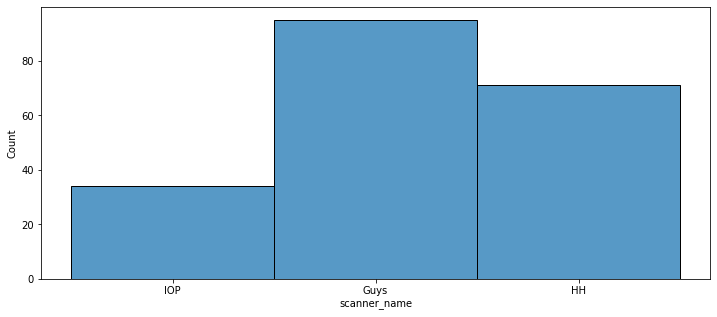

In [17]:
plt.figure(figsize=(12, 5))
sns.histplot(data=our_df, x="scanner_name")

As we can see below all 2 scanners Guys and HH have similar distribution and have lot of scans between 50-70 age. In other terms they have almost equal distribution and we do not need to worry about what to keep or not keep in our learning-unlearning datasets. 

IOP on the other hand has less scans(40 scans) and most of its scans are from younger people with peak at 30 years. How to choose train and test now as we have two equally distributed datasets and IOP as skewed?

* Pick randomly into train learning, train unlearning and validation bucket from Guys and HH as they seem to be equally distributed.
* From IOP, there are 5 scans between 50-70. Put all of them into train unlearning bucket. We dont need to learn much from these images hence dont add them to learning bucket. These 5 scans are important as they lie in same age range peak as that of Guys, HH so must be used for unlearning.
* From rest of IOP (29 remaining) randomly sample 5 of them into validation. rest 24 of them must be used during training learning.


Use the above while building dataset class



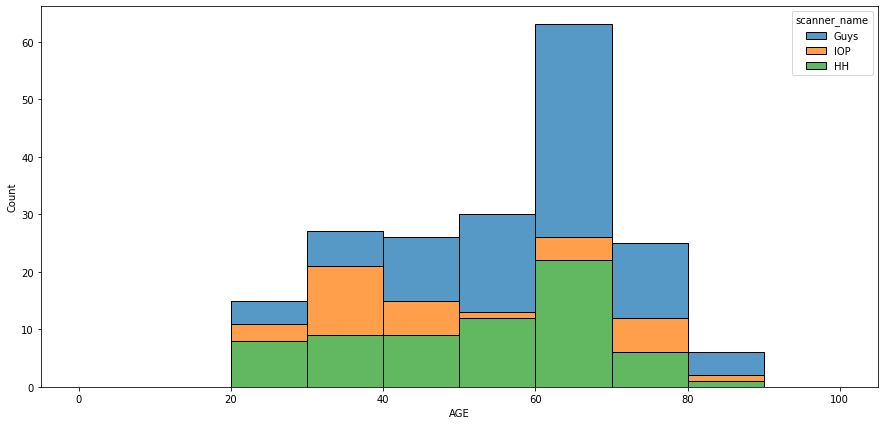

In [ ]:
plt.figure(figsize=(15, 7))
sns.histplot(data=filtered_df,x="AGE", hue="scanner_name", multiple="stack", binwidth=10, binrange=(0,100))

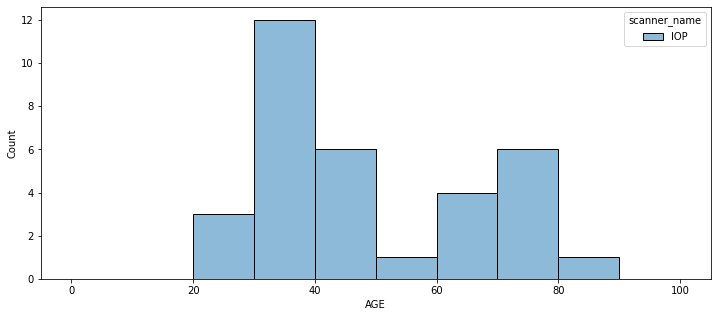

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(data=filtered_df[filtered_df["scanner_name"] == "IOP"],x="AGE", hue="scanner_name", binwidth=10, binrange=(0,100))

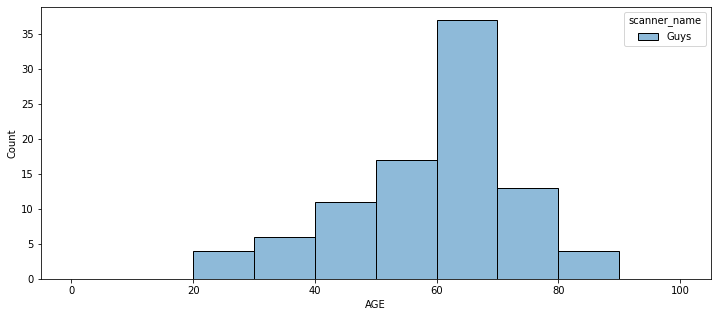

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(data=filtered_df[filtered_df["scanner_name"] == "Guys"],x="AGE", hue="scanner_name", binwidth=10, binrange=(0,100))

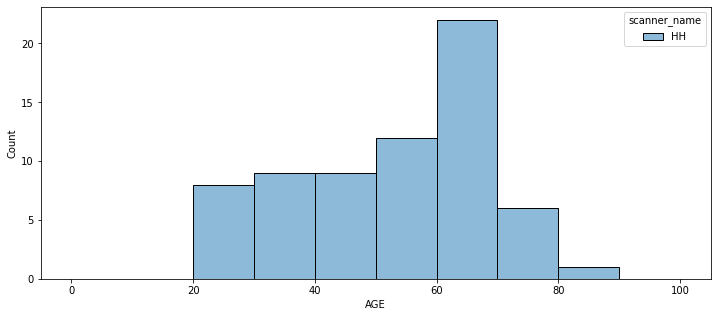

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(data=filtered_df[filtered_df["scanner_name"] == "HH"],x="AGE", hue="scanner_name", binwidth=10, binrange=(0,100))

# Dataset Creation

In [18]:
def place_into_buckets(age_disc, scanner_name):
    """ 
    flag 0,1,2 = learn, unlearn, validation
    - From IOP if its between 50-70 put it in unlearn bucket
    - From IOP if its not between 50-70 put it learn and validation bucket with probs of 0.75 and 0.25
    - From others put it in learn with 0.4, in unlearn with 0.3, in validation with 0.3 prob
    """
    
    if ((scanner_name == "IOP") and (age_disc in ["50-60", "60-70"]) ):
      flag = 1
    elif ((scanner_name == "IOP") and (age_disc not in ["50-60", "60-70"]) ):
      flag = np.random.choice(a=[0, 2], p= [0.75, 0.25])
    else:
      flag = np.random.choice(a=[0, 1, 2], p=[0.5, 0.3, 0.2] )

    if (flag == 0):
      return "train_learn"
    elif (flag == 1):
      return "train_unlearn"
    else:
        return "validation"
        


In [19]:
def categorize_scanner( scanner_name):
    """ 
    flag 0,1,2 = IOP, Guys, HH
    """
    
    if (scanner_name == "IOP") :
      flag = 0
    elif (scanner_name == "Guys"):
      flag = 1
    else:
      flag = 2

    return flag

In [20]:
filtered_df['dataset_flag'] = filtered_df.apply(lambda x: place_into_buckets(x['age_disc'],x['scanner_name']),axis=1)

In [21]:
filtered_df["scanner_flag"] = filtered_df.apply(lambda x: categorize_scanner(x['scanner_name']),axis=1)

In [22]:
filtered_df[filtered_df["AGE"].isnull() == True]

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path,age_disc,dataset_flag,scanner_flag
8,435,1,165,70,1,5,5,4,NaN,1,2006-07-10,NaN,435,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,NaN,train_learn,0
171,623,1,180,80,1,1,1,5,NaN,1,2006-09-25,NaN,623,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,NaN,train_learn,1


In [23]:
filtered_df['AGE'] = filtered_df['AGE'].fillna((filtered_df['AGE'].mean()))

In [24]:
filtered_df[filtered_df["AGE"].isnull() == True]

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path,age_disc,dataset_flag,scanner_flag


In [25]:
filtered_df.head()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path,age_disc,dataset_flag,scanner_flag
0,60,1,180,75,1,2,1,5,1974-10-26,1,2005-07-08,30.699521,60,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,30-40,validation,1
1,428,2,163,75,1,2,1,4,1951-01-08,1,2006-07-24,55.540041,428,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60,train_unlearn,1
2,429,2,155,61,1,2,2,4,1951-01-08,1,2006-07-24,55.540041,429,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60,train_unlearn,1
3,430,2,166,70,1,4,5,5,1934-07-02,1,2006-07-04,72.005476,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,70-80,train_learn,0
4,431,2,163,58,1,2,2,5,1947-10-05,1,2006-07-17,58.781656,431,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60,train_unlearn,1


From below count plot it is evident that

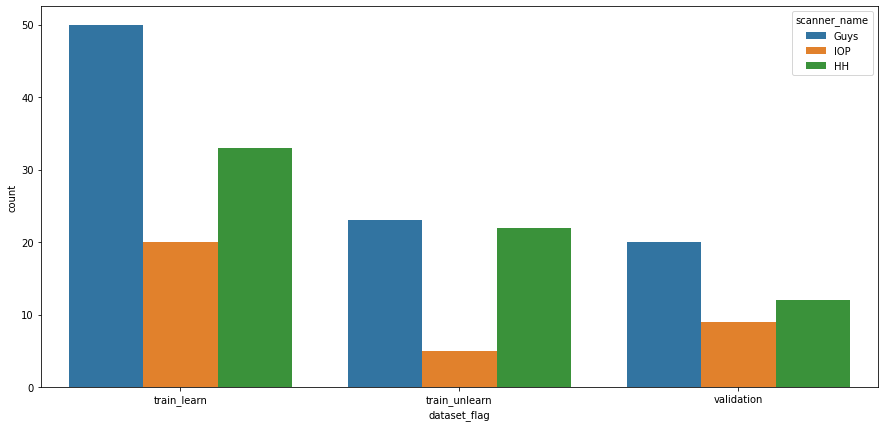

In [ ]:
plt.figure(figsize=(15, 7))
sns.countplot(x="dataset_flag", data=filtered_df, hue="scanner_name")

<Figure size 1440x720 with 0 Axes>

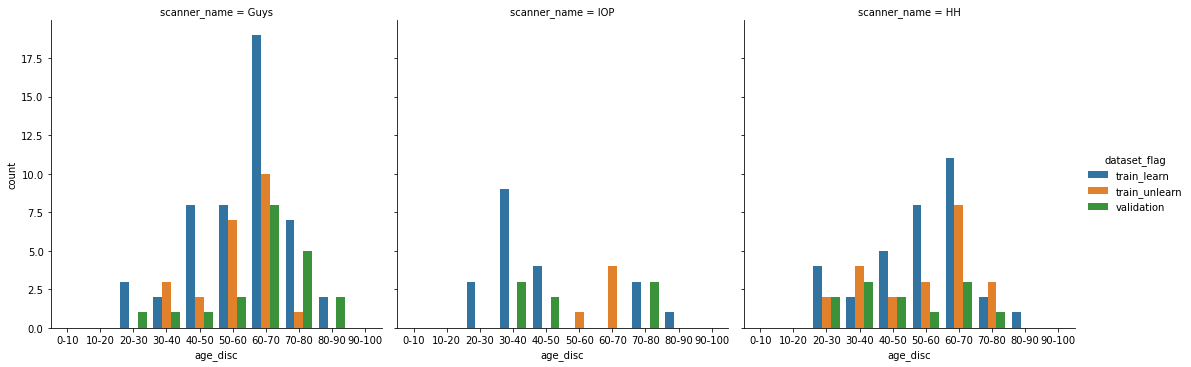

In [ ]:
plt.figure(figsize=(20, 10))
sns.catplot(x="age_disc", data=filtered_df, col="scanner_name", hue="dataset_flag", kind="count")

In [ ]:
fp = filtered_df["file_path"].iloc[0]

In [26]:
train_learn_df = filtered_df[filtered_df["dataset_flag"] == "train_learn"]
train_unlearn_df = filtered_df[filtered_df["dataset_flag"] == "train_unlearn"]
validation_df = filtered_df[filtered_df["dataset_flag"] == "validation"]

In [27]:
print(train_learn_df.shape)
print(train_unlearn_df.shape)
print(validation_df.shape)

(91, 19)
(65, 19)
(38, 19)


In [28]:
z_64_slices = []
for i in range(0, 128, 2):
  z_64_slices.append(i)

In [29]:
z_64_slices[0:4]

[0, 2, 4, 6]

In [30]:
def load_4D(name):
        model_np = np.zeros(shape=(128, 128, 128))
        resamplng_shape = (128, 128, 128)
        X_nb = nb.load(name)
        #print(X_nb)
        X_np = X_nb.dataobj
        #print(X_np)
        x_dim, y_dim, z_dim = X_np.shape
        #print(x_dim, y_dim, z_dim)
        x_ltail = (resamplng_shape[0] - x_dim)//2 
        y_ltail = (resamplng_shape[1] - y_dim)//2
        z_ltail = (resamplng_shape[2] - z_dim)//2
        #print(x_ltail,y_ltail,z_ltail)

        x_rtail = resamplng_shape[0] - x_ltail - 1
        y_rtail = resamplng_shape[1] - y_ltail - 1
        z_rtail = resamplng_shape[2] - z_ltail - 1
        #print(x_rtail,y_rtail,z_rtail)
        model_np[x_ltail:x_rtail, y_ltail:y_rtail, z_ltail:z_rtail] = X_np[:, :, :]
        #z_32_slices = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127]
        model_np = model_np[:, :, z_64_slices]
        model_np = np.expand_dims(model_np, axis=0)
        #print(model_np.shape)
        #print(model_np)
        return model_np

def imgnorm(N_I,index1=0.0001,index2=0.0001):
    I_sort = np.sort(N_I.flatten())
    I_min = I_sort[int(index1*len(I_sort))]
    I_max = I_sort[-int(index2*len(I_sort))]
    N_I =1.0*(N_I-I_min)/(I_max-I_min)
    N_I[N_I>1.0]=1.0
    N_I[N_I<0.0]=0.0
    N_I2 = N_I.astype(np.float32)
    return N_I2

def Norm_Zscore(img):
    img= (img-np.mean(img))/np.std(img) 
    return img

def save_img(I_img,savename):
    I2 = sitk.GetImageFromArray(I_img,isVector=False)
    sitk.WriteImage(I2,savename)

In [31]:
class Dataset(Data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, df = filtered_df, iterations =1, norm=True):
        self.df = df
        self.norm = norm
        self.iterations = iterations
        
  def __len__(self):
        'Denotes the total number of samples'
        return self.df.shape[0] * self.iterations

  def __getitem__(self, step):
        'Generates one sample of data'
        # index_pair = np.random.permutation(len(self.names)) [0:4]
        """
        fp = filtered_df["file_path"].iloc[step]
        sn = filtered_df["scanner_name"].iloc[step]
        dafl = filtered_df["dataset_flag"].iloc[step]
        agdi = filtered_df["age_disc"].iloc[step]
        """
        fp = filtered_df["file_path"].iloc[step]
        sf = filtered_df["scanner_flag"].iloc[step]
        age = filtered_df["AGE"].iloc[step]

        img = load_4D(fp)   
        
        if self.norm:
            # return  Norm_Zscore(imgnorm(img_A)) , Norm_Zscore(imgnorm(img_B))
            return  imgnorm(img), age, sf
        else:
            return img, age, sf

In [32]:
training_generator = Data.DataLoader(Dataset(train_learn_df, 1, True), batch_size=7,shuffle=False)

In [ ]:
for  X, Y, Z in training_generator:
  print(torch.max(X))
  print(X.shape)
  print(Y, Z)
  del X
  break

tensor(1.)
torch.Size([7, 1, 128, 128, 64])
tensor([30.6995, 55.5400, 55.5400, 72.0055, 58.7817, 57.7385, 73.9001],
       dtype=torch.float64) tensor([1, 1, 1, 0, 1, 1, 0])


# Model Building

In [ ]:
mytnsr = torch.randn(size = (4, 1, 2, 2, 2))
mytnsr1 = mytnsr.view(4, -1)
print(mytnsr1.shape)

mytnsr2 = mytnsr.view(-1, 2)
print(mytnsr2.shape)

mytnsr3 = mytnsr.view(-1, 8)
print(mytnsr3.shape)

del mytnsr, mytnsr1, mytnsr2, mytnsr3

torch.Size([4, 8])
torch.Size([16, 2])
torch.Size([4, 8])


In [33]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.feature = nn.Sequential()      # Define the feature extractor
        self.feature.add_module('f_conv1_1', nn.Conv3d(1, 32, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_1_1', nn.ReLU(True))
        self.feature.add_module('f_bn1_1', nn.BatchNorm3d(32))
        self.feature.add_module('f_conv1_2', nn.Conv3d(32, 32, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_1_2', nn.ReLU(True))
        self.feature.add_module('f_bn1_2', nn.BatchNorm3d(32))
        self.feature.add_module('f_pool1', nn.MaxPool3d(2))

        self.feature.add_module('f_conv2_1', nn.Conv3d(32, 64, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_2_1', nn.ReLU(True))
        self.feature.add_module('f_bn2_1', nn.BatchNorm3d(64))
        self.feature.add_module('f_conv2_2', nn.Conv3d(64, 64, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_2_2', nn.ReLU(True))
        self.feature.add_module('f_bn2_2', nn.BatchNorm3d(64))
        self.feature.add_module('f_pool2', nn.MaxPool3d(2))

        self.feature.add_module('f_conv3_1', nn.Conv3d(64, 64, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_3_1', nn.ReLU(True))
        self.feature.add_module('f_bn3_1', nn.BatchNorm3d(64))
        self.feature.add_module('f_conv3_2', nn.Conv3d(64, 64, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_3_2', nn.ReLU(True))
        self.feature.add_module('f_bn3_2', nn.BatchNorm3d(64))
        self.feature.add_module('f_pool3', nn.MaxPool3d(2))

        self.feature.add_module('f_conv4_1', nn.Conv3d(64, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_4_1', nn.ReLU(True))
        self.feature.add_module('f_bn4_1', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv4_2', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_4_2', nn.ReLU(True))
        self.feature.add_module('f_bn4_2', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv4_3', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_4_3', nn.ReLU(True))
        self.feature.add_module('f_bn4_3', nn.BatchNorm3d(96))
        self.feature.add_module('f_pool4', nn.MaxPool3d(2))

        self.feature.add_module('f_conv5_1', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_5_1', nn.ReLU(True))
        self.feature.add_module('f_bn5_1', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv5_2', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_5_2', nn.ReLU(True))
        self.feature.add_module('f_bn5_2', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv5_3', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_5_3', nn.ReLU(True))
        self.feature.add_module('f_bn5_3', nn.BatchNorm3d(96))
        self.feature.add_module('f_pool5', nn.MaxPool3d(2))

        self.feature.add_module('f_conv6_1', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_6_1', nn.ReLU(True))
        self.feature.add_module('f_bn6_1', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv6_2', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_6_2', nn.ReLU(True))
        self.feature.add_module('f_bn6_2', nn.BatchNorm3d(96))
        self.feature.add_module('f_conv6_3', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_6_3', nn.ReLU(True))
        self.feature.add_module('f_bn6_3', nn.BatchNorm3d(96))
        self.feature.add_module('f_pool6', nn.MaxPool3d(2))

        """
        self.feature.add_module('f_conv7_1', nn.Conv3d(96, 96, kernel_size=3, padding=1))
        self.feature.add_module('f_relu_7_1', nn.ReLU(True))
        self.feature.add_module('f_bn7_1', nn.BatchNorm3d(96))
        self.feature.add_module('f_features', nn.MaxPool3d(2))
        """

        self.embeddings = nn.Sequential()
        self.embeddings.add_module('r_fc1', nn.Linear(384, 96))
        self.embeddings.add_module('r_relu1', nn.ReLU(True))


    def forward(self, x):
        batch_size = x.shape[0]
        feature = self.feature(x)
        #print(feature.shape)

        #Changed below code from feature.view(-1, 384)
        feature = feature.view(batch_size, -1)
        #print(feature.shape)
        feature_embedding = self.embeddings(feature)
        return feature_embedding

class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc2', nn.Linear(96, 32))
        self.regressor.add_module('r_relu2', nn.ReLU(True))
        self.regressor.add_module('r_pred', nn.Linear(32, 1))

    def forward(self, x):
        regression = self.regressor(x)
        return regression

class DomainPredictor(nn.Module):
    def __init__(self, nodes=3):
        super(DomainPredictor, self).__init__()
        self.nodes = nodes
        self.domain = nn.Sequential()
        self.domain.add_module('d_fc2', nn.Linear(96, 32))
        self.domain.add_module('d_relu2', nn.ReLU(True))
        self.domain.add_module('r_dropout', nn.Dropout3d(p=0.2))
        self.domain.add_module('d_fc3', nn.Linear(32, nodes))
        self.domain.add_module('d_pred', nn.Softmax(dim=1))

    def forward(self, x):
        domain_pred = self.domain(x)
        return domain_pred


In [ ]:
del encoder, regressor, domain_predictor
torch.cuda.empty_cache()

encoder = Encoder().to("cuda")
regressor = Regressor().to("cuda")
domain_predictor = DomainPredictor(nodes=3).to("cuda")

In [ ]:
del encoder, regressor, domain_predictor
torch.cuda.empty_cache()

In [ ]:
for  X in training_generator:
  X = X.to("cuda")
  print(X.shape)
  enc_feats = encoder(X)
  print(enc_feats.shape)
  regressor_op = regressor(enc_feats)
  print(regressor_op.shape)
  dp_op = domain_predictor(enc_feats)
  print(dp_op.shape)
  del enc_feats, regressor_op, dp_op, X 
  torch.cuda.empty_cache()
  break

torch.Size([7, 1, 128, 128, 64])
torch.Size([7, 96, 2, 2, 1])
torch.Size([7, 384])
torch.Size([7, 96])
torch.Size([7, 1])
torch.Size([7, 3])


# Loss Functions and Miscellaneous

In [34]:
class confusion_loss(nn.Module):
    def __init__(self, task=0):
        super(confusion_loss, self).__init__()
        self.task = task

    def forward(self, x, target):
        # We only care about x
        log = torch.log(x)
        log_sum = torch.sum(log, dim=1)
        normalised_log_sum = torch.div(log_sum,  x.size()[1])
        loss = torch.mul(torch.sum(normalised_log_sum, dim=0), -1)
        return loss

In [ ]:
criteron = nn.MSELoss()     # Change this to DANN_loss normal
domain_criterion = nn.CrossEntropyLoss()

# Normal Training - without unlearning

In [ ]:
del encoder_wou, regressor_wou
torch.cuda.empty_cache()

In [ ]:
del encoder_wou, regressor_wou
torch.cuda.empty_cache()

encoder_wou = Encoder().to("cuda")
regressor_wou = Regressor().to("cuda")
#domain_predictor_wou = DomainPredictor(nodes=3).to("cuda")

In [ ]:
regressor_loss_wou = nn.MSELoss() 
lr=1e-4
#domain_criterion_wou = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(list(encoder_wou.parameters()) + list(regressor_wou.parameters()), lr=lr ) 
model_dir = '/content/drive/My Drive/Image_Registration_Project/mri_harmonization'

LOSS_PATH = "/content/drive/My Drive/Image_Registration_Project/mri_harmonization"
if not os.path.isdir(model_dir):
  os.mkdir(model_dir)


In [ ]:
def run_one_epoch(epoch = 1):
  example_number = 0

  for X, Y, Z in training_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()

    #bool_X_input = torch.isnan(X).any()
    #bool_Y_input = torch.isnan(Y).any()
    
    encoder_feats = encoder_wou(X)
    #bool_encoder_out = torch.isnan(encoder_feats).any()
    predicted_age = regressor_wou(encoder_feats)
    #bool_regressor_out = torch.isnan(predicted_age).any()
    loss = regressor_loss_wou(Y, predicted_age)

    #print(bool_X_input, bool_Y_input, bool_encoder_out, bool_regressor_out)

    optimizer.zero_grad()          
    loss.backward() 
    optimizer.step()

    del X, Y, Z, encoder_feats, predicted_age
    torch.cuda.empty_cache()
    example_number = example_number + 1

  if (epoch%2 == 0):
      modelname = model_dir + '/' + "without_unlearning_" + str(epoch) + '.pth'
      torch.save({"encoder_wou_model": encoder_wou.state_dict(), "regressor_wou_model": regressor_wou.state_dict()}, modelname)
      print("epoch: {}".format(epoch))
      print("Losses: {}".format(loss))
      print("Saving model checkpoints")
      print("======= =============== ===========")
      # Save the losses each epoch so we can plot them live
      myloss = loss.detach()
      myloss = myloss.cpu()
      np.save(LOSS_PATH, np.array(myloss))
      print()



In [ ]:
epochs = 11
for e in range(epochs):
  run_one_epoch(epoch=e)

epoch: 0
Losses: 643.62109375
Saving model checkpoints
======= =============== ===========

epoch: 2
Losses: 410.50823974609375
Saving model checkpoints
======= =============== ===========

epoch: 4
Losses: 317.92193603515625
Saving model checkpoints
======= =============== ===========

epoch: 6
Losses: 289.123779296875
Saving model checkpoints
======= =============== ===========

epoch: 8
Losses: 283.73828125
Saving model checkpoints
======= =============== ===========

epoch: 10
Losses: 278.4912109375
Saving model checkpoints
======= =============== ===========



# Validation - without unlearning

In [67]:
validation_generator = Data.DataLoader(Dataset(train_learn_df, 1, True), batch_size=5,shuffle=False)

In [93]:
del encoder_wou_val, regressor_wou_val
torch.cuda.empty_cache()


In [94]:
encoder_wou_val = Encoder().to("cuda")
regressor_wou_val = Regressor().to("cuda")

In [95]:
checkpoint = torch.load('/content/drive/My Drive/Image_Registration_Project/mri_harmonization/without_unlearning_10.pth')
encoder_wou_val.load_state_dict(checkpoint['encoder_wou_model'])
regressor_wou_val.load_state_dict(checkpoint['regressor_wou_model'])

encoder_wou_val.eval()
regressor_wou_val.eval()


Regressor(
  (regressor): Sequential(
    (r_fc2): Linear(in_features=96, out_features=32, bias=True)
    (r_relu2): ReLU(inplace=True)
    (r_pred): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [96]:
def run_one_epoch_val( epoch = 1):
  batch_num = 0
  batch_size = 5
  embedding_dim = 96
  out_np = np.zeros((batch_size, embedding_dim))
  for X, Y, Z in validation_generator:
    X = X.to("cuda").float()
    Y = Y.to("cuda").float()

    #print(X.shape)
    encoder_feats = encoder_wou_val(X)

    #predicted_age = regressor_wou_val(encoder_feats)

    encoder_feats_cpu = encoder_feats.detach().to("cpu")
    encoder_feats_np = encoder_feats_cpu.numpy()

    print(encoder_feats_np.shape)
    print(batch_num * batch_size)

    del X, Y, Z, encoder_feats, encoder_feats_cpu

    out_np = np.append(out_np, encoder_feats_np, axis=0)
    batch_num = batch_num + 1    

    del encoder_feats_np
    torch.cuda.empty_cache()
    
    print("Batch_number: ", batch_num)
  
  return out_np



In [100]:
!nvidia-smi

Sat Mar 27 14:04:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |   8903MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [98]:
!ps -a | grep "python"

In [99]:
torch.cuda.empty_cache()

In [101]:
epochs = 1
for e in range(epochs):
  mynp = run_one_epoch_val(epoch=e)

(5, 96)
0
Batch_number:  1
(5, 96)
5
Batch_number:  2
(5, 96)
10
Batch_number:  3
(5, 96)
15
Batch_number:  4
(5, 96)
20
Batch_number:  5
(5, 96)
25
Batch_number:  6
(5, 96)
30
Batch_number:  7
(5, 96)
35
Batch_number:  8
(5, 96)
40
Batch_number:  9
(5, 96)
45
Batch_number:  10
(5, 96)
50
Batch_number:  11
(5, 96)
55
Batch_number:  12
(5, 96)
60
Batch_number:  13
(5, 96)
65
Batch_number:  14
(5, 96)
70
Batch_number:  15
(5, 96)
75
Batch_number:  16
(5, 96)
80
Batch_number:  17
(5, 96)
85
Batch_number:  18
(1, 96)
90
Batch_number:  19


In [102]:
mynp.shape

(96, 96)

In [107]:
mynp1 = mynp[5:, :]

In [108]:
df_subset = pd.DataFrame(mynp1)

In [109]:
df_subset.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,30.616865,0.0,0.0,29.636530,32.162609,0.0,0.0,0.0,0.0,30.805445,0.0,0.0,27.131577,0.0,31.778507,0.0,0.0,0.0,0.0,0.0,0.0,29.672586,30.342209,0.0,28.215734,28.790695,0.0,28.185011,30.725029,0.0,33.416763,0.0,31.006927,0.0,0.0,0.0,29.666250,0.0,28.132376,27.829586,...,0.0,30.405193,0.0,31.827873,30.070169,29.150635,0.0,0.0,0.0,29.719776,30.209934,30.314497,30.427010,31.553383,25.343884,0.0,0.0,0.0,29.653334,30.662853,27.368155,28.072155,29.638378,0.0,0.0,0.0,27.987888,29.380348,0.0,0.0,31.659018,33.969982,29.509283,0.0,0.0,0.0,0.0,28.383293,29.676710,30.095675
1,30.664804,0.0,0.0,29.692415,32.200027,0.0,0.0,0.0,0.0,30.871675,0.0,0.0,27.205019,0.0,31.850492,0.0,0.0,0.0,0.0,0.0,0.0,29.740578,30.386000,0.0,28.254168,28.836729,0.0,28.231327,30.789753,0.0,33.470104,0.0,31.069756,0.0,0.0,0.0,29.716040,0.0,28.158857,27.892620,...,0.0,30.467821,0.0,31.878548,30.131351,29.197927,0.0,0.0,0.0,29.767109,30.247681,30.384060,30.475931,31.611649,25.385765,0.0,0.0,0.0,29.706793,30.710014,27.436964,28.116722,29.693666,0.0,0.0,0.0,28.028595,29.423454,0.0,0.0,31.719362,34.037632,29.566994,0.0,0.0,0.0,0.0,28.436028,29.727428,30.140671
2,30.734240,0.0,0.0,29.751266,32.293324,0.0,0.0,0.0,0.0,30.937899,0.0,0.0,27.237865,0.0,31.913082,0.0,0.0,0.0,0.0,0.0,0.0,29.819029,30.460699,0.0,28.321264,28.902399,0.0,28.298887,30.828403,0.0,33.525120,0.0,31.143936,0.0,0.0,0.0,29.785677,0.0,28.211412,27.948410,...,0.0,30.547079,0.0,31.944427,30.198132,29.252363,0.0,0.0,0.0,29.840092,30.282213,30.480629,30.530735,31.674507,25.447525,0.0,0.0,0.0,29.747129,30.768290,27.484926,28.164555,29.755785,0.0,0.0,0.0,28.087196,29.507608,0.0,0.0,31.782143,34.111771,29.616951,0.0,0.0,0.0,0.0,28.493282,29.803076,30.195576
3,30.417494,0.0,0.0,29.472265,31.937672,0.0,0.0,0.0,0.0,30.610649,0.0,0.0,26.970722,0.0,31.594017,0.0,0.0,0.0,0.0,0.0,0.0,29.486300,30.158499,0.0,28.026247,28.603622,0.0,28.022591,30.556517,0.0,33.187546,0.0,30.770584,0.0,0.0,0.0,29.466650,0.0,27.974796,27.651051,...,0.0,30.222765,0.0,31.634369,29.892658,28.975607,0.0,0.0,0.0,29.516582,30.026585,30.093826,30.242973,31.351078,25.203802,0.0,0.0,0.0,29.491686,30.455414,27.198788,27.901491,29.446293,0.0,0.0,0.0,27.808722,29.200756,0.0,0.0,31.442652,33.781162,29.334930,0.0,0.0,0.0,0.0,28.212021,29.490421,29.899071
4,30.698364,0.0,0.0,29.739122,32.246872,0.0,0.0,0.0,0.0,30.905611,0.0,0.0,27.214806,0.0,31.893221,0.0,0.0,0.0,0.0,0.0,0.0,29.785009,30.437826,0.0,28.303766,28.882793,0.0,28.269720,30.809299,0.0,33.502735,0.0,31.117882,0.0,0.0,0.0,29.743433,0.0,28.198538,27.953930,...,0.0,30.508001,0.0,31.917027,30.166517,29.257067,0.0,0.0,0.0,29.801256,30.282646,30.410639,30.519690,31.646763,25.427948,0.0,0.0,0.0,29.752193,30.733301,27.465902,28.149921,29.736565,0.0,0.0,0.0,28.077177,29.492826,0.0,0.0,31.756920,34.108162,29.620255,0.0,0.0,0.0,0.0,28.479614,29.782131,30.178524
5,30.714108,0.0,0.0,29.717493,32.251934,0.0,0.0,0.0,0.0,30.888861,0.0,0.0,27.198252,0.0,31.876564,0.0,0.0,0.0,0.0,0.0,0.0,29.784336,30.424158,0.0,28.285154,28.883392,0.0,28.258377,30.804308,0.0,33.499447,0.0,31.102524,0.0,0.0,0.0,29.748808,0.0,28.209122,27.909575,...,0.0,30.507536,0.0,31.922306,30.160646,29.225973,0.0,0.0,0.0,29.794954,30.297825,30.399446,30.509872,31.646461,25.413464,0.0,0.0,0.0,29.746532,30.734900,27.453793,28.147100,29.711803,0.0,0.0,0.0,28.063751,29.465839,0.0,0.0,31.742844,34.086582,29.596415,0.0,0.0,0.0,0.0,28.458530,29.754663,30.175671
6,30.655893,0.0,0.0,29.694265,32.189259,0.0,0.0,0.0,0.0,30.827135,0.0,0.0,27.167133,0.0,31.837259,0.0,0.0,0.0,0.0,0.0,0.0,29.721872,30.369825,0.0,28.231459,28.828053,0.0,28.215166,30.751352,0.0,33.427677,0.0,31.033997,0.0,0.0,0.0,29.680441,0.0,28.158424,27.872194,...,0.0,30.457958,0.0,31.855900,30.109861,29.188057,0.0,0.0,0.0,29.722523,30.226877,30.342470,30.461266,3

In [110]:
train_learn_df.reset_index(inplace=True)

In [111]:
train_learn_df.head()

,index,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path,age_disc,dataset_flag,scanner_flag
0,3,430,2,166,70,1,4,5,5,1934-07-02,1,2006-07-04,72.005476,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,70-80,train_learn,0
1,5,432,1,186,100,1,2,1,5,1948-10-20,1,2006-07-17,57.738535,432,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60,train_learn,1
2,8,435,1,165,70,1,5,5,4,NaN,1,2006-07-10,55.362837,435,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,NaN,train_learn,0
3,9,436,1,190,73,1,1,1,1,1978-01-18,1,2006-05-25,28.347707,436,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,20-30,train_learn,2
4,10,437,2,178,84,1,2,1,1,1950-10-19,1,2006-05-25,55.597536,437,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60,train_learn,2


In [ ]:
validation_df.reset_index(inplace=True)

In [ ]:
validation_df.head()

,level_0,index,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path,age_disc,dataset_flag,scanner_flag
0,0,3,430,2,166,70,1,4,5,5,1934-07-02,1,2006-07-04,72.005476,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,70-80,validation,0
1,1,8,435,1,165,70,1,5,5,4,NaN,1,2006-07-10,NaN,435,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,NaN,validation,0
2,2,23,450,1,170,64,3,4,5,5,1938-05-08,1,2006-11-10,68.509240,450,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,60-70,validation,1
3,3,26,453,1,185,98,1,2,7,2,1943-02-25,1,2006-07-27,63.416838,453,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,60-70,validation,2
4,4,27,454,1,180,100,1,1,7,5,1974-04-02,1,2006-10-30,32.577687,454,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,30-40,validation,1


In [112]:
result = pd.merge(left=train_learn_df, right=df_subset, how="inner", left_index=True, right_index=True, validate="one_to_one")

# Validation and Visualization

In [ ]:
sample_np = np.random.randn(100, 384)

In [117]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)


In [118]:
tsne_results = tsne.fit_transform(mynp1)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 90 nearest neighbors...
[t-SNE] Indexed 91 samples in 0.000s...
[t-SNE] Computed neighbors for 91 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 91 / 91
[t-SNE] Mean sigma: 0.250666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.442505
[t-SNE] KL divergence after 300 iterations: 0.260926
t-SNE done! Time elapsed: 3.7065112590789795 seconds


In [119]:
df_subset = pd.DataFrame(tsne_results, columns = ['tsne-2d-one','tsne-2d-two'])

In [120]:
result["tsne-2d-one"] = tsne_results[:, 0]
result["tsne-2d-two"] = tsne_results[:, 1]

In [121]:
result.head()

,index,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,our_ixi_id,scanner_name,contrast_type,file_path,age_disc,dataset_flag,scanner_flag,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,tsne-2d-one,tsne-2d-two
0,3,430,2,166,70,1,4,5,5,1934-07-02,1,2006-07-04,72.005476,430,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,70-80,train_learn,0,30.616865,0.0,0.0,29.636530,32.162609,0.0,0.0,0.0,0.0,30.805445,0.0,0.0,27.131577,0.0,31.778507,0.0,0.0,0.0,0.0,0.0,...,0.0,31.827873,30.070169,29.150635,0.0,0.0,0.0,29.719776,30.209934,30.314497,30.427010,31.553383,25.343884,0.0,0.0,0.0,29.653334,30.662853,27.368155,28.072155,29.638378,0.0,0.0,0.0,27.987888,29.380348,0.0,0.0,31.659018,33.969982,29.509283,0.0,0.0,0.0,0.0,28.383293,29.676710,30.095675,-12.177871,7.799654
1,5,432,1,186,100,1,2,1,5,1948-10-20,1,2006-07-17,57.738535,432,Guys,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60,train_learn,1,30.664804,0.0,0.0,29.692415,32.200027,0.0,0.0,0.0,0.0,30.871675,0.0,0.0,27.205019,0.0,31.850492,0.0,0.0,0.0,0.0,0.0,...,0.0,31.878548,30.131351,29.197927,0.0,0.0,0.0,29.767109,30.247681,30.384060,30.475931,31.611649,25.385765,0.0,0.0,0.0,29.706793,30.710014,27.436964,28.116722,29.693666,0.0,0.0,0.0,28.028595,29.423454,0.0,0.0,31.719362,34.037632,29.566994,0.0,0.0,0.0,0.0,28.436028,29.727428,30.140671,-8.380808,2.868613
2,8,435,1,165,70,1,5,5,4,NaN,1,2006-07-10,55.362837,435,IOP,T1,/content/drive/My Drive/Image_Registration_Pro...,NaN,train_learn,0,30.734240,0.0,0.0,29.751266,32.293324,0.0,0.0,0.0,0.0,30.937899,0.0,0.0,27.237865,0.0,31.913082,0.0,0.0,0.0,0.0,0.0,...,0.0,31.944427,30.198132,29.252363,0.0,0.0,0.0,29.840092,30.282213,30.480629,30.530735,31.674507,25.447525,0.0,0.0,0.0,29.747129,30.768290,27.484926,28.164555,29.755785,0.0,0.0,0.0,28.087196,29.507608,0.0,0.0,31.782143,34.111771,29.616951,0.0,0.0,0.0,0.0,28.493282,29.803076,30.195576,4.126670,-5.765513
3,9,436,1,190,73,1,1,1,1,1978-01-18,1,2006-05-25,28.347707,436,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,20-30,train_learn,2,30.417494,0.0,0.0,29.472265,31.937672,0.0,0.0,0.0,0.0,30.610649,0.0,0.0,26.970722,0.0,31.594017,0.0,0.0,0.0,0.0,0.0,...,0.0,31.634369,29.892658,28.975607,0.0,0.0,0.0,29.516582,30.026585,30.093826,30.242973,31.351078,25.203802,0.0,0.0,0.0,29.491686,30.455414,27.198788,27.901491,29.446293,0.0,0.0,0.0,27.808722,29.200756,0.0,0.0,31.442652,33.781162,29.334930,0.0,0.0,0.0,0.0,28.212021,29.490421,29.899071,-15.926909,8.591712
4,10,437,2,178,84,1,2,1,1,1950-10-19,1,2006-05-25,55.597536,437,HH,T1,/content/drive/My Drive/Image_Registration_Pro...,50-60,train_learn,2,30.698364,0.0,0.0,29.739122,32.246872,0.0,0.0,0.0,0.0,30.905611,0.0,0.0,27.214806,0.0,31.893221,0.0,0.0,0.0,0.0,0.0,...,0.0,31.917027,30.166517,29.257067,0.0,0.0,0.0,29.801256,30.282646,30.410639,30.519690,31.646763,25.427948,0.0,0.0,0.0,29.752193,30.733301,27.465902,28.149921,29.736565,0.0,0.0,0.0,28.077177,29.492826,0.0,0.0,31.756920,34.108162,29.620255,0.0,0.0,0.0,0.0,28.479614,29.782131,30.178524,-0.195845,-2.644053


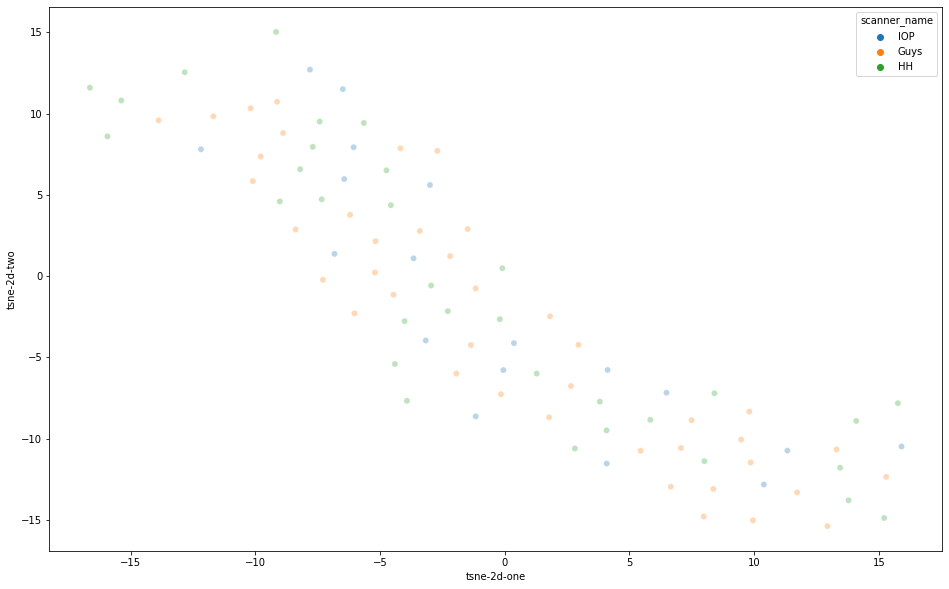

In [122]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two", hue = "scanner_name",
    data=result,
    legend="full",
    alpha=0.3)

# Training with unlearning